In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Supervised Fine-Tuning with integrated GenAI Evaluation


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Ftuning%2Fsft_gemini_automatic_evaluation.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<b>Share to:</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn logo">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky logo">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/5a/X_icon_2.svg" alt="X logo">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit logo">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook logo">
</a>            

| Author(s) |
| --- |
| Kelsi Lakey, [Ivan Nardini](https://github.com/inardini) |

This notebook demonstrates a powerful new feature in Vertex AI: [integrated evaluation for supervised fine-tuning (SFT)]((https://cloud.devsite.corp.google.com/vertex-ai/generative-ai/docs/models/gemini-use-supervised-tuning#create_a_text_model_supervised_tuning_job)).

Traditionally, tuning a model and evaluating it are two separate, time-consuming steps. This creates a slow feedback loop, making it difficult to iterate quickly.

This notebook shows you the new, integrated workflow where you can get performance metrics on model checkpoints *as they are being trained*. By adding a simple EvaluationConfig to your tuning job, you can now get performance metrics using Gen AI Evaluation Service on model checkpoints as they are being trained.

This gives allows you:

*   Faster Iteration: See if a tuning run is working in minutes, not hours.
*   Cost Savings: Identify and stop bad runs early.
*   Better Models: Get a clear view of how your model improves over time, helping you pinpoint the best checkpoint and avoid overfitting.


You will learn how to:

* Configure an EvaluationConfig to define custom, model-based metrics.  
* Launch a supervised fine-tuning job for gemini-2.5-flash with automatic evaluation enabled.  
* Monitor the job and retrieve performance results for each checkpoint programmatically.  
* Find and analyze your tuning and evaluation results in the Vertex AI Experiments UI.

## Get started

### Install Google Gen AI SDK and other required packages

The new Google Gen AI SDK provides a unified interface to Gemini through both the Gemini Developer API and the Gemini API on Vertex AI. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

In [ ]:
%pip install --upgrade --user --quiet google-genai google-cloud-aiplatform gradio plotly

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.


In [ ]:
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

You'll need a Google Cloud project with the Vertex AI API enabled. Authenticate your notebook environment to continue.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
# Use the environment variable if the user doesn't provide Project ID.
import os
from google import genai
from google.cloud import aiplatform

# Please fill in these values for your project.
PROJECT_ID = "[your-project-id]"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

# A GCS bucket is required for tuning and evaluation artifacts.
BUCKET_NAME = "[your-gcs-bucket-name]"  # @param {type:"string", placeholder: "[your-gcs-bucket-name]", isTemplate: true}
BUCKET_URI = f"gs://{BUCKET_NAME}"

# Create the GCS bucket if it doesn't exist
!gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

# Initialize the Vertex AI and GenAI SDKs
aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)
client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

### Import libraries

In [ ]:
import time
import pandas as pd
import uuid
from google.genai import types

## Initialize model

Define the model to be tuned. `gemini-2.5-flash` is the Gemini text model support supervised tuning.

In [ ]:
base_model = "gemini-2.5-flash"

## Prepare your datasets

For integrated evaluation, you need both a training dataset and a validation dataset. The model trains on the former and is tested against the latter at each checkpoint. The data should be in JSONL format, where each line is a JSON object containing prompt and response keys.

Example format:

```
{"contents": [{"role": "user", "parts": [{"text": "Honesty is usually the best policy. It is disrespectful to lie to someone. If you don't want to date someone, you should say so.  Sometimes it is easy to be honest. ... It is not necessary for everyone around you to know that you are turning down a date.\n\nProvide a summary of the article in two or three sentences:\n\n"}]}, {"role": "model", "parts": [{"text": "Tell the truth. Use a \"compliment sandwich\". Be direct. Treat the person with respect. Communicate effectively."}]}]}
```

For this tutorial, we will use public sample datasets.

In [ ]:
training_dataset_uri = "gs://cloud-samples-data/ai-platform/generative_ai/gemini-2_0/text/sft_train_data.jsonl"
validation_dataset_uri = "gs://cloud-samples-data/ai-platform/generative_ai/gemini-2_0/text/sft_validation_data.jsonl"

## Define the Evaluation Config

This is the core of the new feature.

The `EvaluationConfig` object tells the tuning job how to measure performance using another model (an "autorater") to judge the quality of your tuned model's responses. Here, we'll define a `metric` to evaluate the "fluency" of the output.


In [ ]:
evaluation_config = types.EvaluationConfig(
    # Required. Define a list of metrics. A minimum of 1 is required.
    metrics=[
        types.Metric(
            name="fluency",
            prompt_template="Evaluate the sentence fluency of the response. Provide a score from 1-5.\n RESPONSE: {response}",
            # Optional. Guide the autorater's persona for better results.
            judge_model_system_instruction="You are a professional editor specializing in linguistics.",
        ),
    ],
    # Required. Define where to store the detailed, row-by-row evaluation results.
    output_config=types.OutputConfig(
        gcs_destination=types.GcsDestination(
            output_uri_prefix=f"{BUCKET_URI}/evaluation"
        )
    ),
    # Optional. Configure the autorater itself.
    autorater_config=types.AutoraterConfig(
        # The number of validation samples to evaluate for each checkpoint.
        # This is a trade-off: more samples = better metrics but higher cost/time.
        sampling_count=6,
    ),
)

## Fine-tune the Model with Integrated Evaluation

Now we launch the tuning job. We provide the base model, datasets, and our evaluation\_config. The service will handle the rest, automatically running evaluations on checkpoints.

*Note: The default hyperparameter settings are optimized for most use cases. You can customize parameters like adapter\_size to address specific performance needs.*

In [ ]:
tuned_model_display_name = "gemini-flash-integrated-eval-demo" + f"_{str(uuid.uuid4())[:8]}"

training_dataset = {
    "gcs_uri": training_dataset_uri,
}

validation_dataset = types.TuningValidationDataset(
    gcs_uri=validation_dataset_uri,
)

# Start the tuning job. This is an asynchronous call.
# The SDK's tuning implementation is experimental and may change in future versions.
sft_tuning_job = client.tunings.tune(
    base_model=base_model,
    training_dataset=training_dataset,
    config=types.CreateTuningJobConfig(
        tuned_model_display_name=tuned_model_display_name,
        validation_dataset=validation_dataset,
        evaluation_config=evaluation_config,
    ),
)

In [ ]:
# Get the tuning job for status checks.
tuning_job = client.tunings.get(name=sft_tuning_job.name)
print(tuning_job)

## Monitor the tuning job

Tuning time depends on several factors, such as training data size, number of epochs, learning rate multiplier, etc.


**⚠️ It will take \~45 mins for this model tuning job and evaluation to complete.**

In [ ]:
print(
    "Monitoring job... This will take time. You can safely close this notebook and come back later."
)

while not sft_tuning_job.state in [
    types.JobState.JOB_STATE_CANCELLED,
    types.JobState.JOB_STATE_FAILED,
    types.JobState.JOB_STATE_SUCCEEDED,
]:
    time.sleep(600)  # Check status every 10 minutes
    sft_tuning_job.refresh()
    print(f"Current job state: {str(sft_tuning_job.state.name)}")

print(f"Job finished with state: {sft_tuning_job.state.name}")

## Get the final tuned model and experiment details


In [ ]:
tuned_model = tuning_job.tuned_model.endpoint
experiment_name = tuning_job.experiment

print("Tuned model experiment:", experiment_name)
print("Tuned model endpoint resource name:", tuned_model)

## View GenAI Evaluation results

Evaluation results for each checkpoint are logged to the associated Vertex Experiment. You can view them in the UI or access them programmatically.

Each checkpoint will be described with a `tuning-evaluation-checkpoint-#` \
Experiment Run. This will include the following GenAI Evaluation metrics:
  - Error message (if failed)
  - `gcsDestination` (location of row based evaluation results)
  - `gcsSource` (location of evaluation dataset)
  - Aggregated evaluation metric results
    - For SDK: `AVERAGE` and `STANDARD_DEVIATION` values for each metric
    - For API: User defined aggregation metrics
    - Aggregated results are indexed in the order they were defined in the Evaluation Config

### View GenAI Evaluation Metrics using Vertex AI Experiments SDK

In [ ]:
# Locate the Vertex AI Experiment and list the evaluation runs for each checkpoint
experiment_runs = aiplatform.ExperimentRun.list(experiment=experiment_name)
for run in experiment_runs:
    if "-evaluation-" in run.name:
        print(f"--- Results for Run: {run.name} ---")
        print(pd.DataFrame.from_dict(run.get_metrics(), orient="index"))
        print("\n")

### View Results in the Google Cloud Console

You can also get a rich, visual view of the results:

1. Navigate to the **Vertex AI \> Generative AI \> Tuning** page in the Google Cloud Console.  
2. Click on your tuning job (gemini-flash-integrated-eval-demo).  
3. On the Details page, click the link under the **Experiment** field. This will take you directly to the Vertex AI Experiments page where you can compare metrics across all checkpoints.

Here you can see an example:

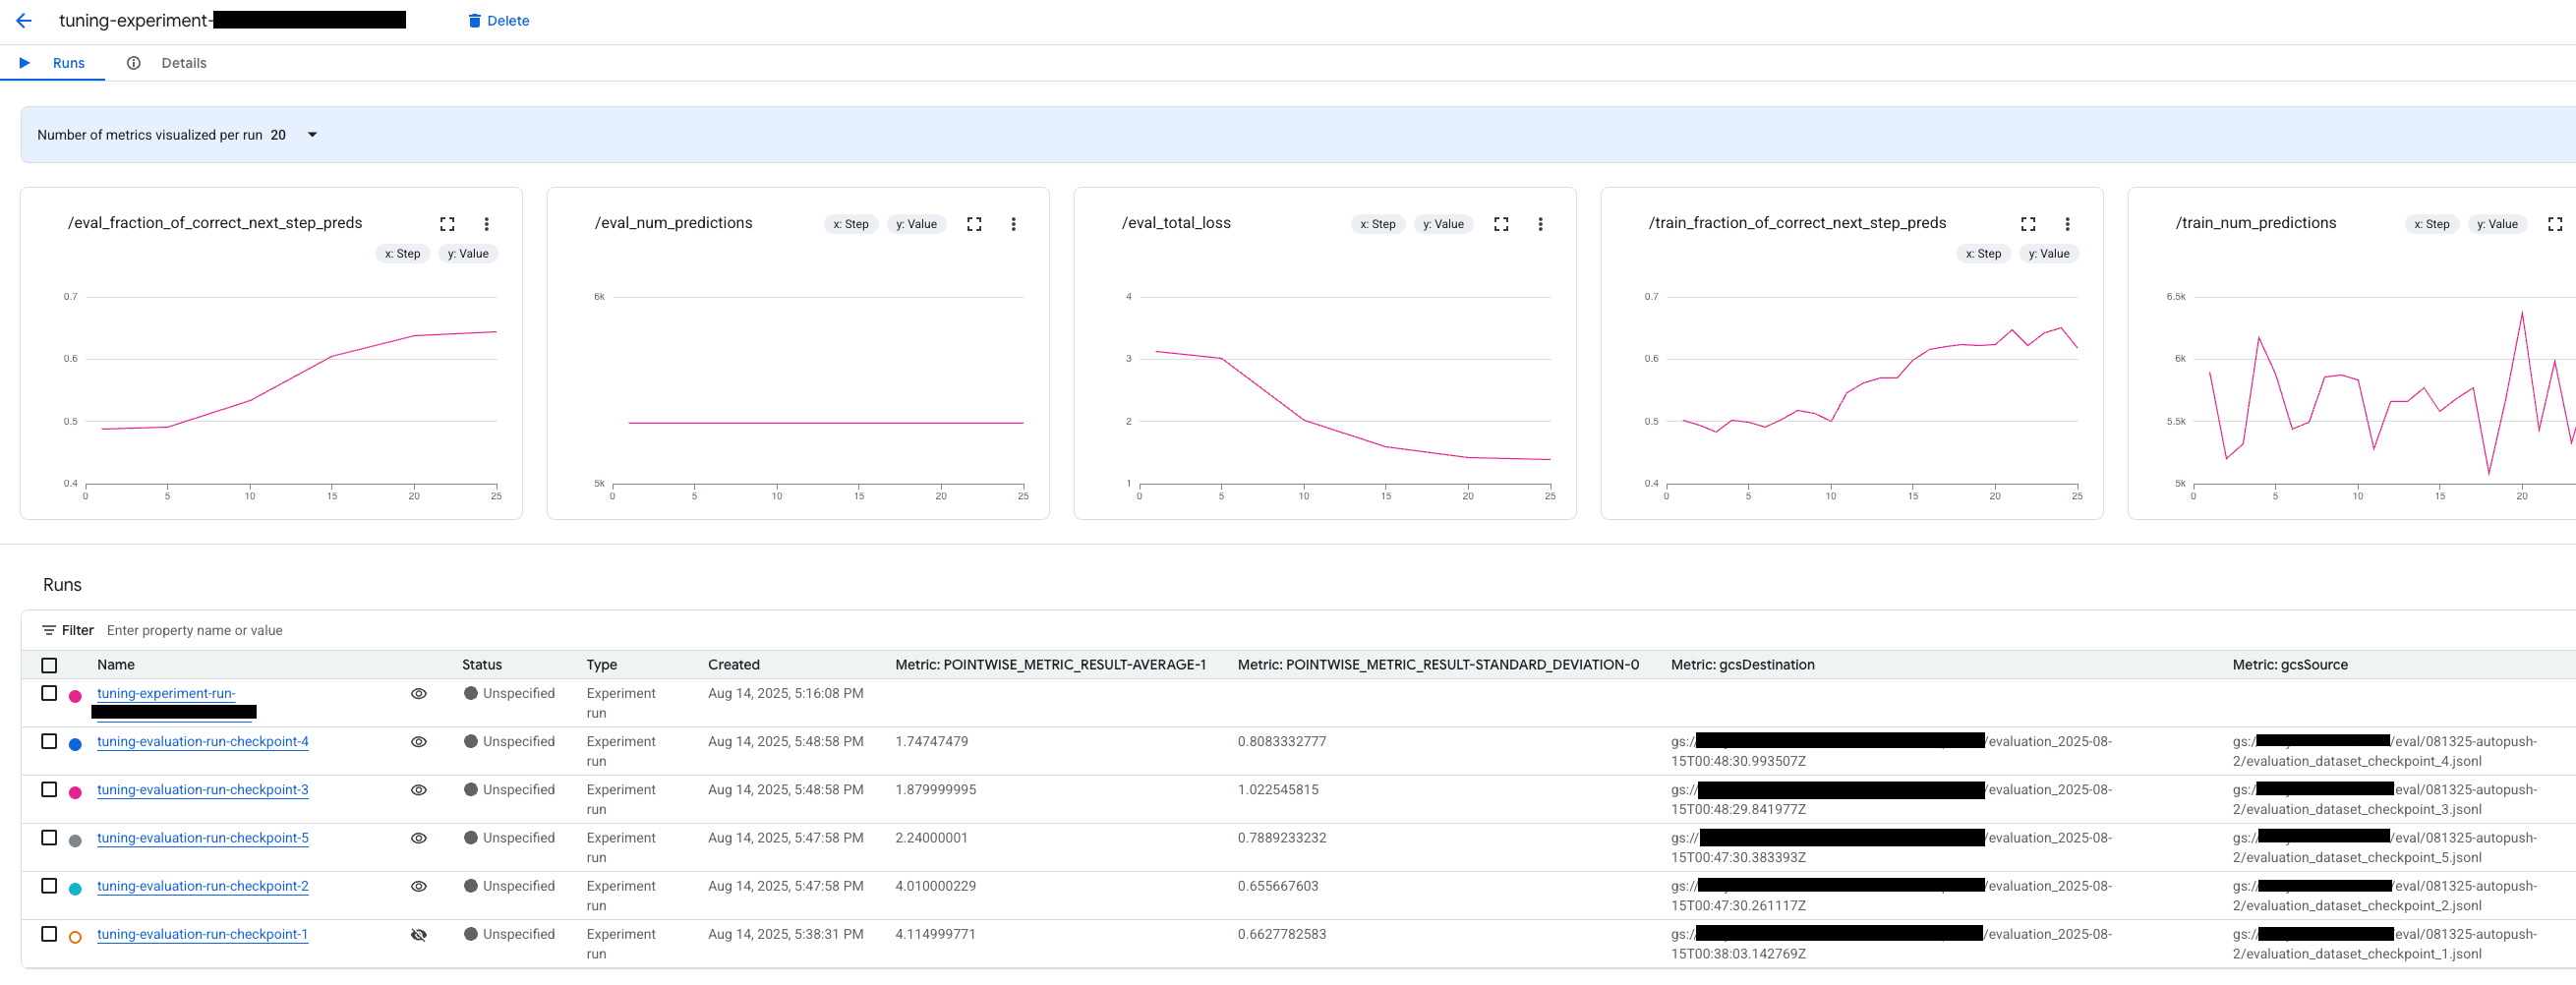

## (Optional) Evaluation Results Viewer

Launch a Gradio app to visualize evaluation results from a GCS bucket.

In [ ]:
import gradio as gr
import pandas as pd
import plotly.graph_objects as go
from google.cloud import storage
import json
from typing import Dict
import numpy as np


class EvaluationViewer:
    def __init__(self):
        self.client = None
        self.bucket_name = None
        self.evaluation_data = {}

    def connect_to_gcs(self, bucket_name: str) -> str:
        """Connect to GCS bucket and load evaluation data."""
        try:
            self.client = storage.Client()
            self.bucket_name = bucket_name
            self.bucket = self.client.bucket(bucket_name)

            # Load evaluation data
            self.load_evaluation_data()

            return f"✓ Successfully connected to bucket: {bucket_name}\n" \
                   f"Found {len(self.evaluation_data)} evaluation runs"
        except Exception as e:
            return f"✗ Error connecting to bucket: {str(e)}"

    def load_evaluation_data(self):
        """Load all evaluation data from the bucket."""
        self.evaluation_data = {}

        # List all evaluation folders
        blobs = self.bucket.list_blobs(prefix="evaluation/evaluation_")

        eval_folders = set()
        for blob in blobs:
            parts = blob.name.split('/')
            # Only add folders that start with 'evaluation_' and don't contain 'dataset_checkpoint'
            if len(parts) >= 2 and parts[1].startswith('evaluation_') and 'dataset_checkpoint' not in parts[1]:
                eval_folders.add(parts[1])

        # Sort folders by timestamp to assign checkpoint numbers
        sorted_folders = sorted(eval_folders)

        # Load data from each evaluation folder with checkpoint naming
        for idx, folder in enumerate(sorted_folders, 1):
            timestamp = folder.replace('evaluation_', '')
            checkpoint_name = f"checkpoint_{idx}"
            self.evaluation_data[timestamp] = {
                'aggregation': [],
                'results': [],
                'checkpoint_name': checkpoint_name
            }

            # Load aggregation results
            agg_blob = self.bucket.blob(f"evaluation/{folder}/aggregation_results.jsonl")
            if agg_blob.exists():
                content = agg_blob.download_as_text()
                for line in content.strip().split('\n'):
                    if line:
                        self.evaluation_data[timestamp]['aggregation'].append(json.loads(line))

            # Load evaluation results (sample first 100 for performance)
            res_blob = self.bucket.blob(f"evaluation/{folder}/evaluation_results.jsonl")
            if res_blob.exists():
                content = res_blob.download_as_text()
                lines = content.strip().split('\n')
                for line in lines[:100]:  # Limit to first 100 for performance
                    if line:
                        self.evaluation_data[timestamp]['results'].append(json.loads(line))

    def get_overview_stats(self) -> Dict:
        """Calculate overview statistics for all evaluation runs."""
        if not self.evaluation_data:
            return {}

        stats = {
            'total_runs': len(self.evaluation_data),
            'total_samples': 0,
            'overall_avg': [],
            'overall_std': [],
            'latest_run': None,
            'latest_checkpoint': None,
            'latest_avg': None,
            'latest_std': None,
            'best_run': None,
            'best_checkpoint': None,
            'best_avg': float('-inf'),
            'best_std': None,
            'worst_run': None,
            'worst_checkpoint': None,
            'worst_avg': float('inf'),
            'worst_std': None
        }

        # Process each evaluation run
        for timestamp, data in sorted(self.evaluation_data.items(), reverse=True):
            avg_score = None
            std_score = None

            for agg in data['aggregation']:
                if agg['aggregationMetric'] == 'AVERAGE':
                    avg_score = agg['pointwiseMetricResult']['score']
                elif agg['aggregationMetric'] == 'STANDARD_DEVIATION':
                    std_score = agg['pointwiseMetricResult']['score']

            if avg_score is not None:
                stats['overall_avg'].append(avg_score)
                if std_score is not None:
                    stats['overall_std'].append(std_score)

                # Track latest run
                if stats['latest_run'] is None:
                    stats['latest_run'] = timestamp
                    stats['latest_checkpoint'] = data.get('checkpoint_name', 'N/A')
                    stats['latest_avg'] = avg_score
                    stats['latest_std'] = std_score

                # Track best and worst
                if avg_score > stats['best_avg']:
                    stats['best_avg'] = avg_score
                    stats['best_std'] = std_score
                    stats['best_run'] = timestamp
                    stats['best_checkpoint'] = data.get('checkpoint_name', 'N/A')

                if avg_score < stats['worst_avg']:
                    stats['worst_avg'] = avg_score
                    stats['worst_std'] = std_score
                    stats['worst_run'] = timestamp
                    stats['worst_checkpoint'] = data.get('checkpoint_name', 'N/A')

            stats['total_samples'] += len(data['results'])

        # Calculate overall statistics
        if stats['overall_avg']:
            stats['global_avg'] = np.mean(stats['overall_avg'])
            stats['global_std'] = np.mean(stats['overall_std']) if stats['overall_std'] else 0
            stats['avg_range'] = (min(stats['overall_avg']), max(stats['overall_avg']))

        return stats

    def get_aggregated_metrics_plot(self) -> go.Figure:
        """Create aggregated metrics visualization."""
        if not self.evaluation_data:
            return go.Figure().add_annotation(text="No evaluation data available", showarrow=False)

        # Prepare data for plotting
        timestamps = []
        checkpoint_labels = []
        averages = []
        std_devs = []

        for timestamp, data in sorted(self.evaluation_data.items()):
            timestamps.append(timestamp[:19])  # Truncate microseconds for readability
            checkpoint_labels.append(data.get('checkpoint_name', 'N/A'))

            avg_score = None
            std_score = None

            for agg in data['aggregation']:
                if agg['aggregationMetric'] == 'AVERAGE':
                    avg_score = agg['pointwiseMetricResult']['score']
                elif agg['aggregationMetric'] == 'STANDARD_DEVIATION':
                    std_score = agg['pointwiseMetricResult']['score']

            averages.append(avg_score if avg_score is not None else 0)
            std_devs.append(std_score if std_score is not None else 0)

        # Create subplots
        fig = go.Figure()

        # Add average scores with error bars
        fig.add_trace(go.Scatter(
            x=timestamps,
            y=averages,
            error_y=dict(
                type='data',
                array=std_devs,
                visible=True
            ),
            mode='lines+markers',
            name='Average Score',
            line=dict(color='blue', width=2),
            marker=dict(size=8),
            text=checkpoint_labels,
            hovertemplate='<b>%{text}</b><br>Time: %{x}<br>Score: %{y:.3f} ± %{error_y.array:.3f}<extra></extra>'
        ))

        fig.update_layout(
            title="Evaluation Metrics Over Time",
            xaxis_title="Evaluation Run",
            yaxis_title="Score",
            hovermode='x unified',
            showlegend=True,
            height=400
        )

        return fig


    def get_evaluation_results_table(self, eval_run: str, start_idx: int = 0, page_size: int = 10) -> pd.DataFrame:
        """Get evaluation results as a paginated table."""
        if not eval_run or eval_run not in self.evaluation_data:
            return pd.DataFrame({"Message": ["Select an evaluation run to view results"]})

        results = self.evaluation_data[eval_run]['results']

        if not results:
            return pd.DataFrame({"Message": ["No results available for this run"]})

        # Prepare data for display
        table_data = []
        end_idx = min(start_idx + page_size, len(results))

        for i in range(start_idx, end_idx):
            result = results[i]
            instance = json.loads(result['jsonInstance'])

            # Extract evaluation score and explanation
            score = None
            explanation = None
            if 'evaluationResults' in result and result['evaluationResults']:
                eval_result = result['evaluationResults'][0]
                if 'pointwiseMetricResult' in eval_result:
                    score = eval_result['pointwiseMetricResult'].get('score', 'N/A')
                    explanation = eval_result['pointwiseMetricResult'].get('explanation', 'N/A')

            table_data.append({
                'Index': i + 1,
                'Request': instance.get('request', 'N/A')[:100] + '...' if len(instance.get('request', '')) > 100 else instance.get('request', 'N/A'),
                'Response': instance.get('response', 'N/A')[:100] + '...' if len(instance.get('response', '')) > 100 else instance.get('response', 'N/A'),
                'Reference': instance.get('reference', 'N/A')[:100] + '...' if len(instance.get('reference', '')) > 100 else instance.get('reference', 'N/A'),
                'Score': score,
                'Explanation': explanation[:100] + '...' if explanation and len(explanation) > 100 else explanation
            })

        return pd.DataFrame(table_data)

    def get_single_result_detail(self, eval_run: str, index: int) -> Dict:
        """Get detailed view of a single evaluation result."""
        if not eval_run or eval_run not in self.evaluation_data:
            return {"error": "Invalid evaluation run"}

        results = self.evaluation_data[eval_run]['results']

        if index < 0 or index >= len(results):
            return {"error": "Invalid index"}

        result = results[index]
        instance = json.loads(result['jsonInstance'])

        # Extract evaluation details
        eval_details = {}
        if 'evaluationResults' in result and result['evaluationResults']:
            eval_result = result['evaluationResults'][0]
            if 'pointwiseMetricResult' in eval_result:
                eval_details = eval_result['pointwiseMetricResult']

        return {
            'request': instance.get('request', 'N/A'),
            'response': instance.get('response', 'N/A'),
            'reference': instance.get('reference', 'N/A'),
            'baseline_model_response': instance.get('baseline_model_response', 'N/A'),
            'score': eval_details.get('score', 'N/A'),
            'explanation': eval_details.get('explanation', 'N/A')
        }


# Initialize the viewer
viewer = EvaluationViewer()

# Create Gradio interface
with gr.Blocks(title="Evaluation Results Viewer") as app:
    gr.Markdown("# 📊 Evaluation Results Viewer")
    gr.Markdown("Load data from your GCS bucket to visualize evaluation metrics and results.")

    with gr.Row():
        bucket_input = gr.Textbox(
            label="GCS Bucket Name",
            placeholder="Enter your GCS bucket name (e.g., my-evaluation-bucket)",
            scale=3
        )
        connect_btn = gr.Button("Load from Bucket", variant="primary", scale=1)

    status_output = gr.Textbox(label="Connection Status", interactive=False)

    with gr.Tabs():
        with gr.Tab("📊 Overview"):
            gr.Markdown("### Evaluation Summary")
            with gr.Row():
                with gr.Column(scale=1):
                    overview_total_runs = gr.Number(label="Total Evaluation Runs", interactive=False)
                    overview_total_samples = gr.Number(label="Total Samples Evaluated", interactive=False)
                with gr.Column(scale=1):
                    overview_global_avg = gr.Number(label="Global Average Score", interactive=False, precision=3)
                    overview_global_std = gr.Number(label="Global Std Deviation", interactive=False, precision=3)

            with gr.Row():
                with gr.Column(scale=1):
                    gr.Markdown("#### Latest Run")
                    overview_latest_checkpoint = gr.Textbox(label="Checkpoint", interactive=False)
                    overview_latest_run = gr.Textbox(label="Timestamp", interactive=False)
                    overview_latest_avg = gr.Number(label="Average Score", interactive=False, precision=3)
                    overview_latest_std = gr.Number(label="Std Deviation", interactive=False, precision=3)
                with gr.Column(scale=1):
                    gr.Markdown("#### Best Run")
                    overview_best_checkpoint = gr.Textbox(label="Checkpoint", interactive=False)
                    overview_best_run = gr.Textbox(label="Timestamp", interactive=False)
                    overview_best_avg = gr.Number(label="Average Score", interactive=False, precision=3)
                    overview_best_std = gr.Number(label="Std Deviation", interactive=False, precision=3)
                with gr.Column(scale=1):
                    gr.Markdown("#### Worst Run")
                    overview_worst_checkpoint = gr.Textbox(label="Checkpoint", interactive=False)
                    overview_worst_run = gr.Textbox(label="Timestamp", interactive=False)
                    overview_worst_avg = gr.Number(label="Average Score", interactive=False, precision=3)
                    overview_worst_std = gr.Number(label="Std Deviation", interactive=False, precision=3)

            gr.Markdown("#### Score Range")
            overview_range = gr.Textbox(label="Min - Max Average Scores", interactive=False)

        with gr.Tab("📈 Aggregated Metrics"):
            gr.Markdown("### Overall Evaluation Metrics")
            metrics_plot = gr.Plot(label="Metrics Over Time")

        with gr.Tab("📋 Evaluation Results"):
            gr.Markdown("### Browse Individual Evaluation Results")

            with gr.Row():
                eval_run_dropdown = gr.Dropdown(
                    label="Select Evaluation Run",
                    choices=[],
                    interactive=True
                )
                refresh_runs_btn = gr.Button("🔄 Refresh", scale=1)

            with gr.Row():
                page_size = gr.Slider(
                    minimum=5,
                    maximum=50,
                    value=10,
                    step=5,
                    label="Results per page"
                )
                page_number = gr.Number(
                    value=1,
                    label="Page",
                    minimum=1,
                    precision=0
                )

            results_table = gr.DataFrame(
                label="Evaluation Results",
                interactive=False,
                wrap=True
            )

        with gr.Tab("🔍 Result Details"):
            gr.Markdown("### Detailed View of Single Result")

            with gr.Row():
                detail_eval_run = gr.Dropdown(
                    label="Select Evaluation Run",
                    choices=[],
                    interactive=True
                )
                result_index = gr.Number(
                    value=0,
                    label="Result Index (0-based)",
                    minimum=0,
                    precision=0
                )
                load_detail_btn = gr.Button("Load Details", variant="primary")

            with gr.Column():
                gr.Markdown("#### Request")
                detail_request = gr.Textbox(label="", lines=5, interactive=False)

                gr.Markdown("#### Response")
                detail_response = gr.Textbox(label="", lines=3, interactive=False)

                gr.Markdown("#### Reference")
                detail_reference = gr.Textbox(label="", lines=3, interactive=False)

                gr.Markdown("#### Baseline Model Response")
                detail_baseline = gr.Textbox(label="", lines=3, interactive=False)

                with gr.Row():
                    detail_score = gr.Number(label="Score", interactive=False)
                    detail_explanation = gr.Textbox(label="Explanation", lines=2, interactive=False)

    # Define interactions
    def connect_and_load(bucket_name):
        status = viewer.connect_to_gcs(bucket_name)

        if "Successfully" in status:
            # Get overview stats
            stats = viewer.get_overview_stats()

            # Update plots
            metrics_fig = viewer.get_aggregated_metrics_plot()

            # Update dropdown choices
            eval_runs = list(viewer.evaluation_data.keys())

            # Format overview outputs
            overview_outputs = [
                stats.get('total_runs', 0),
                stats.get('total_samples', 0),
                stats.get('global_avg', 0),
                stats.get('global_std', 0),
                stats.get('latest_checkpoint', 'N/A'),
                stats.get('latest_run', 'N/A')[:19] if stats.get('latest_run') else 'N/A',
                stats.get('latest_avg', 0),
                stats.get('latest_std', 0),
                stats.get('best_checkpoint', 'N/A'),
                stats.get('best_run', 'N/A')[:19] if stats.get('best_run') else 'N/A',
                stats.get('best_avg', 0),
                stats.get('best_std', 0),
                stats.get('worst_checkpoint', 'N/A'),
                stats.get('worst_run', 'N/A')[:19] if stats.get('worst_run') else 'N/A',
                stats.get('worst_avg', 0),
                stats.get('worst_std', 0),
                f"{stats.get('avg_range', (0, 0))[0]:.3f} - {stats.get('avg_range', (0, 0))[1]:.3f}" if stats.get('avg_range') else 'N/A'
            ]

            return (
                status,
                *overview_outputs,
                metrics_fig,
                gr.update(choices=eval_runs, value=eval_runs[0] if eval_runs else None),
                gr.update(choices=eval_runs, value=eval_runs[0] if eval_runs else None)
            )
        else:
            return (
                status,
                0, 0, 0, 0, 'N/A', 'N/A', 0, 0, 'N/A', 'N/A', 0, 0, 'N/A', 'N/A', 0, 0, 'N/A',
                go.Figure(),
                gr.update(choices=[]),
                gr.update(choices=[])
            )

    def update_results_table(eval_run, page_num, page_size):
        if not eval_run:
            return pd.DataFrame()
        start_idx = (page_num - 1) * page_size
        return viewer.get_evaluation_results_table(eval_run, start_idx, page_size)

    def load_result_details(eval_run, index):
        details = viewer.get_single_result_detail(eval_run, int(index))

        if "error" in details:
            return "", "", "", "", None, details["error"]

        return (
            details['request'],
            details['response'],
            details['reference'],
            details['baseline_model_response'],
            details['score'],
            details['explanation']
        )

    def refresh_runs():
        eval_runs = list(viewer.evaluation_data.keys())
        return (
            gr.update(choices=eval_runs, value=eval_runs[0] if eval_runs else None),
            gr.update(choices=eval_runs, value=eval_runs[0] if eval_runs else None)
        )

    # Connect button events
    connect_btn.click(
        fn=connect_and_load,
        inputs=[bucket_input],
        outputs=[
            status_output,
            overview_total_runs, overview_total_samples,
            overview_global_avg, overview_global_std,
            overview_latest_checkpoint, overview_latest_run, overview_latest_avg, overview_latest_std,
            overview_best_checkpoint, overview_best_run, overview_best_avg, overview_best_std,
            overview_worst_checkpoint, overview_worst_run, overview_worst_avg, overview_worst_std,
            overview_range,
            metrics_plot,
            eval_run_dropdown, detail_eval_run
        ]
    )

    # Update table when dropdown or pagination changes
    eval_run_dropdown.change(
        fn=update_results_table,
        inputs=[eval_run_dropdown, page_number, page_size],
        outputs=[results_table]
    )

    page_number.change(
        fn=update_results_table,
        inputs=[eval_run_dropdown, page_number, page_size],
        outputs=[results_table]
    )

    page_size.change(
        fn=update_results_table,
        inputs=[eval_run_dropdown, page_number, page_size],
        outputs=[results_table]
    )

    # Refresh runs button
    refresh_runs_btn.click(
        fn=refresh_runs,
        outputs=[eval_run_dropdown, detail_eval_run]
    )

    # Load detail button
    load_detail_btn.click(
        fn=load_result_details,
        inputs=[detail_eval_run, result_index],
        outputs=[detail_request, detail_response, detail_reference,
                 detail_baseline, detail_score, detail_explanation]
    )

In [ ]:
app.launch(share=True, height=800)

In [ ]:
app.close()

## Cleaning up

To avoid incurring unexpected charges, it's important to clean up the resources created in this notebook.

In [ ]:
delete_experiments = True
delete_endpoint = True
delete_bucket = True

# Deleting experiment
if delete_experiments:
    experiment = aiplatform.Experiment.list()[0]
    experiment.delete()

# Deleting the endpoint itself removes the resource configuration.
if delete_endpoint:
    endpoint = aiplatform.Endpoint.list()[0]
    endpoint.delete(force=True)

# To fully clean up, you should also delete the model artifacts and dataset from your GCS bucket.
# You can do this via the command line or the Google Cloud Console.
if delete_bucket:
    !gsutil -m rm -r {BUCKET_URI}